## Pakiety/Funkcje

In [2]:
library(psych)
library(caret)
library(klaR)
library(MASS)
library(vegan)
library(car)
library(caret)
library(mclust)
library(mixtools)
library(bestNormalize)
library(fda)

In [3]:
# Step 3: Normalize numeric columns (Min-Max normalization)
normalize <- function(x) {
  (x - min(x)) / (max(x) - min(x))
}


## Dane

In [325]:
Dane_org_untouched <- read.csv(file.choose())
Dane_org = Dane_org_untouched
Dane_org$round_winner <- as.factor(Dane_org$round_winner)

In [380]:
All_data_ind <- sample(1:100000, 100000, replace = FALSE)
Train_ind = All_data_ind[1:80000]
test_ind = All_data_ind[80001:100000]
Dane_v2 = Dane_org_untouched[Train_ind, c(1:14,97)]
Dane <- Dane_org[Train_ind, c(1:14,97)]
Dane_pred <- Dane_org[test_ind, c(1:14,97)]

In [381]:
Dane_norm = Dane
Dane_pred_norm = Dane_pred
# Apply normalization only to numeric columns
Dane_norm[numeric_columns] <- lapply(Dane[numeric_columns], normalize)
Dane_pred_norm[numeric_columns] <- lapply(Dane_pred[numeric_columns], normalize)

In [382]:
names(Dane)

[1] "time_left"      "ct_score"       "t_score"        "map"           
 [5] "bomb_planted"   "ct_health"      "t_health"       "ct_armor"      
 [9] "t_armor"        "ct_money"       "t_money"        "ct_helmets"    
[13] "t_helmets"      "ct_defuse_kits" "round_winner"

In [383]:
head(Dane)

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,round_winner
,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
37010,74.95,1,0,de_inferno,False,484,479,499,294,1050,950,5,3,1,T
40476,109.93,6,0,de_mirage,False,500,500,472,400,31650,9300,5,3,3,CT
32068,69.93,8,13,de_dust2,False,142,100,0,68,7200,10950,0,1,0,CT
86687,63.70,4,11,de_nuke,False,238,138,200,99,900,450,0,0,1,CT
65529,17.34,7,1,de_nuke,True,252,185,300,283,8250,1150,3,3,2,CT
60813,114.93,1,0,de_train,False,500,500,492,0,1150,10750,4,0,1,CT


- time_left - czas do końca rundy w momencie jej zakończenia 
- ct_score - wynik po stronie ct w
- t_score - wynik po stronie t
- map - mapa (str)
- bomb_planted - podłożona/nie w trakcie rundy
- ct_health - całkowite hp po stronie ct
- t_health - całkowite hp po stronnie t
- ct_armor - całkowita wartość ochrony po stronie ct
- t_armor - całkowita wartość ochrony po stronie t
- ct_money - całkowita ilość pieniędzy po stronie ct
- t_money - całkowita ilość pieniędzy po stronie t
- ct_helmet - całkowita liczba hełmów po stronie ct
- t_helmet - całkowita liczba hełmów po stronie t
- ct_defuse_kits - całkowita liczba tzw. defuse kits po stronie ct
- ct_players_alive - całkowita liczba żywych graczy po stronie ct
- round_winner - wynik rundy (T/CT)

## Wykresy

### Normalność danych

Te zmienne ma sens rozpatrywać jako ciągłe

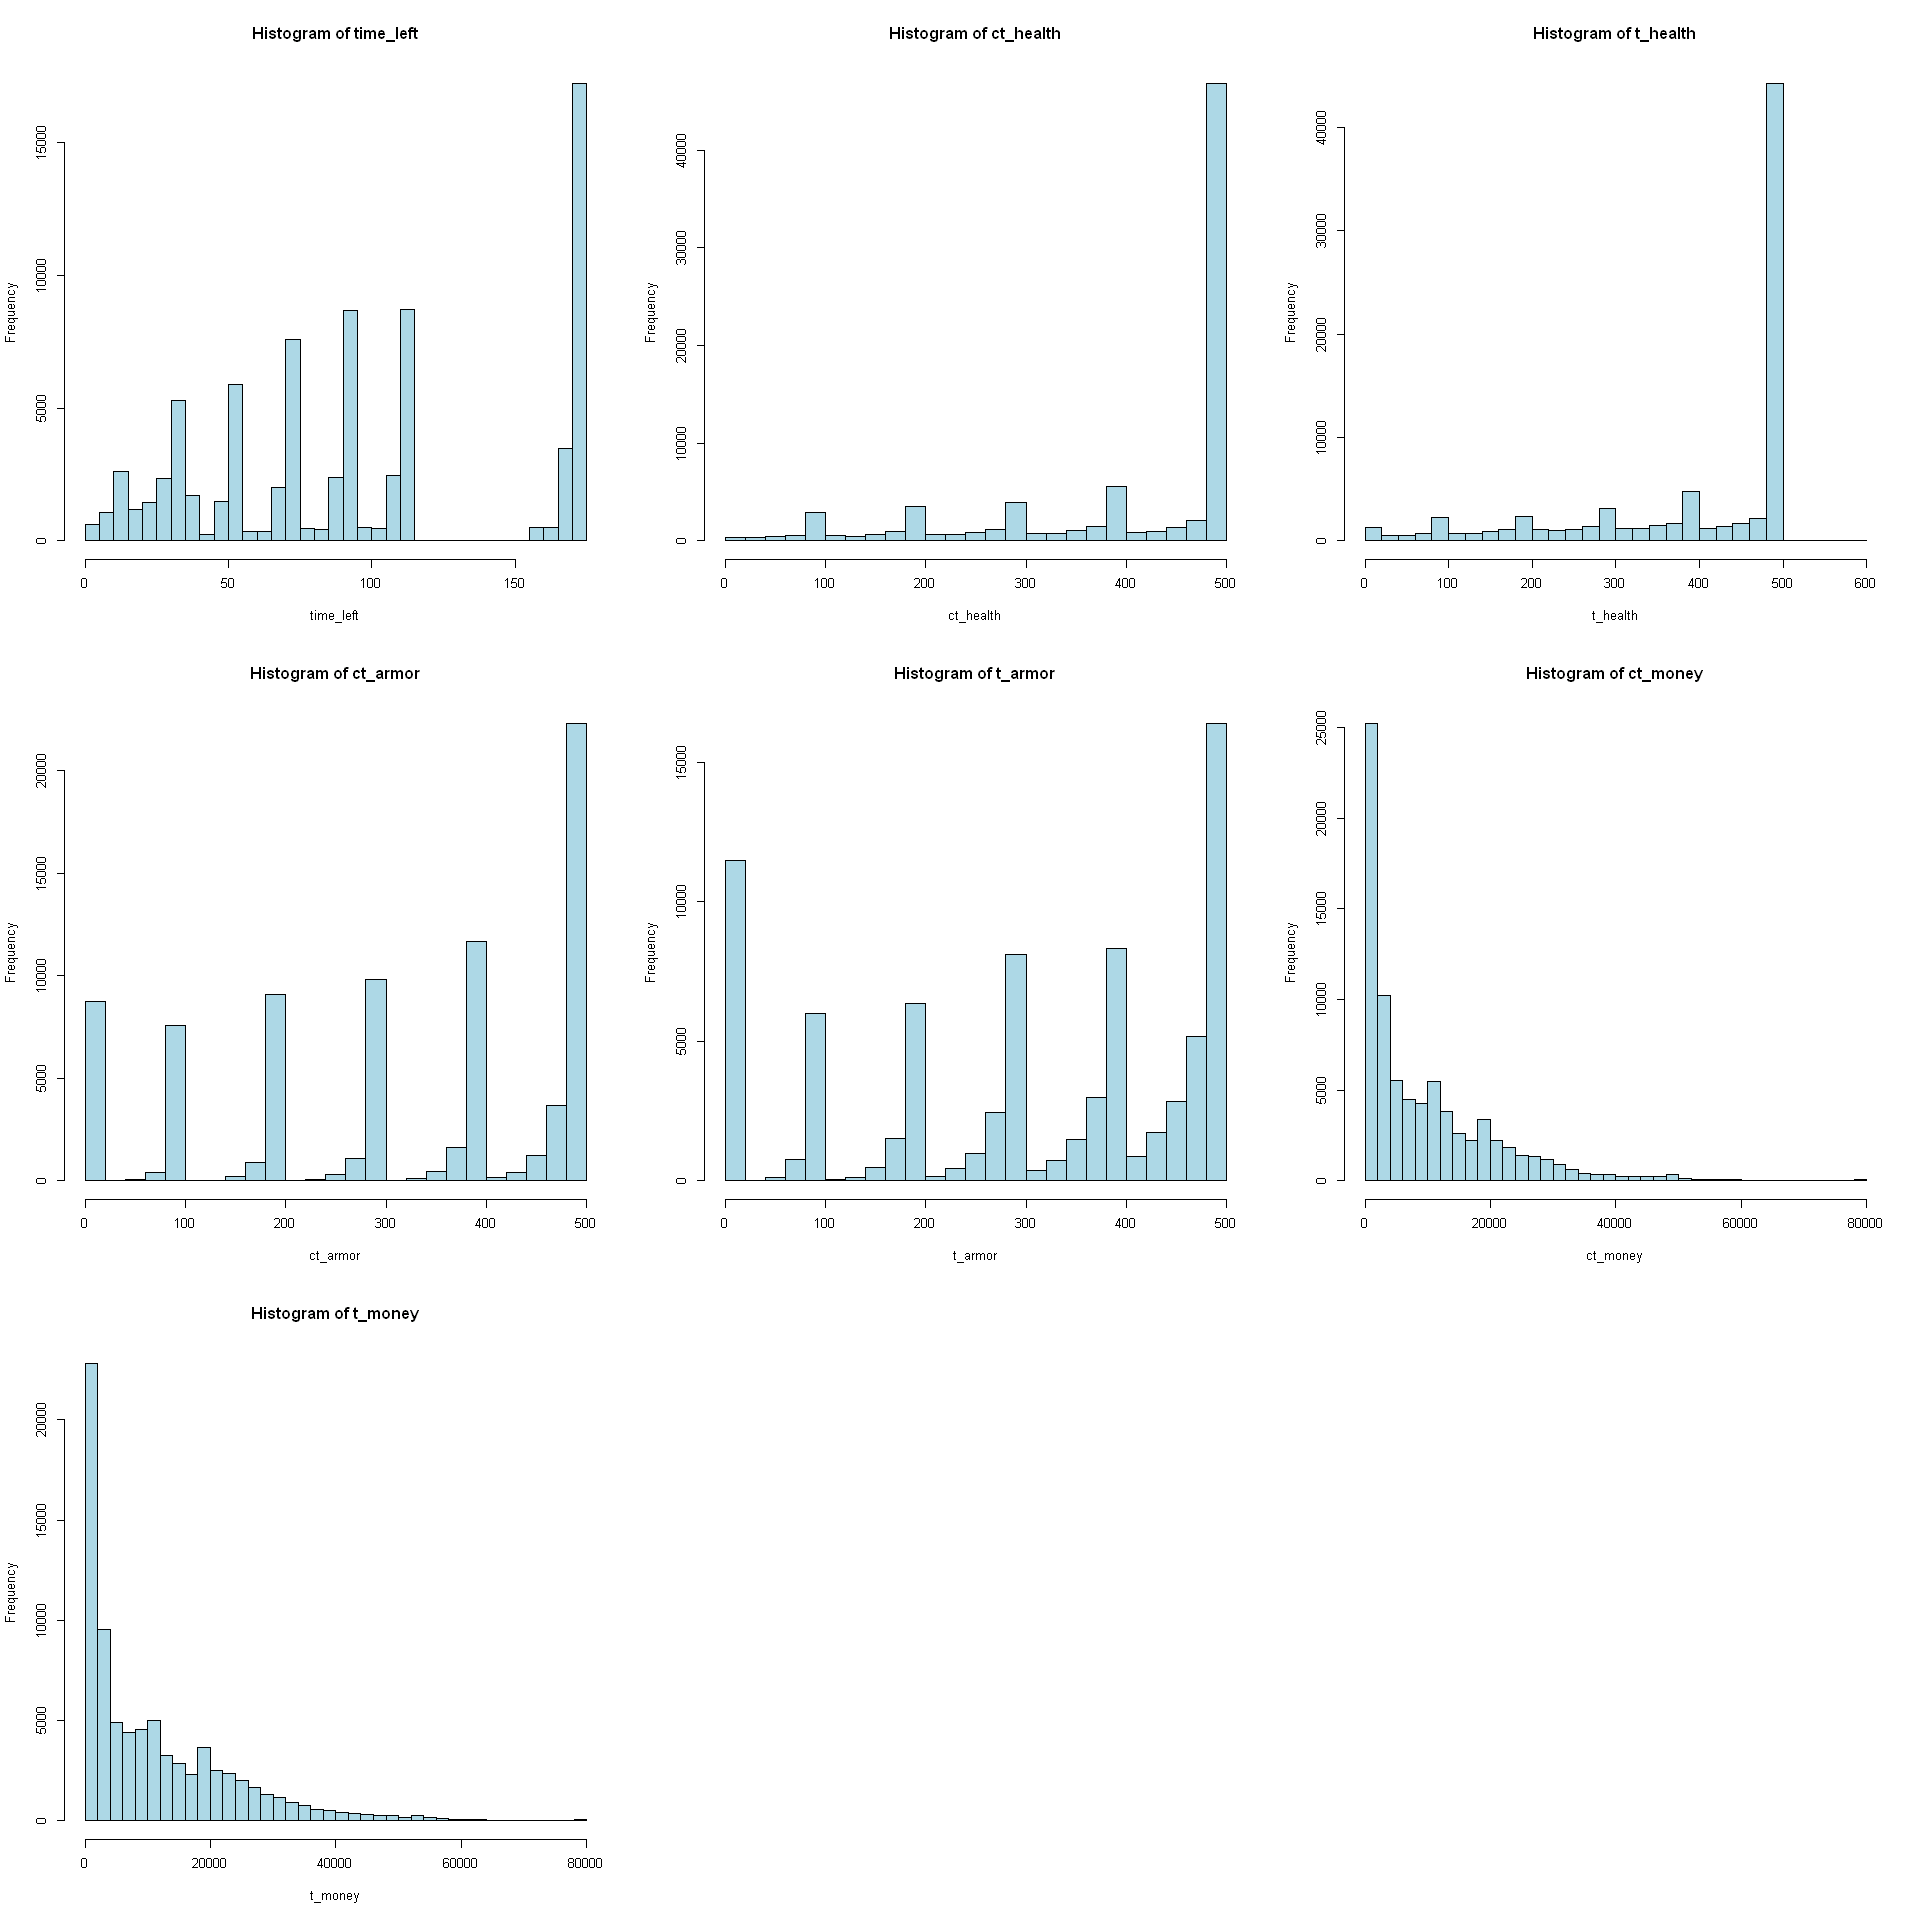

In [384]:
options(repr.plot.width=16, repr.plot.height=16) 
num_cols <- sapply(Dane, is.numeric)
par(mfrow = c(3, 3))
numeric_columns <- names(Dane_v2)[num_cols]
for (col in numeric_columns[c(1,4:9)]) {
  hist(Dane_v2[[col]], main = paste("Histogram of", col), xlab = col, col = "lightblue", breaks = 30,border = "black")
}

Dane da się znormalizować poprzez wyrzucenie skrajnych (chociaż częstych) obserwacji. W przypadku większości wystarczy przekształcenie 'kwantylowe', w przypadku t_health i ct_health potrzeba dodatkowo zlogarytmować dane przed 'kwantylowaniem'

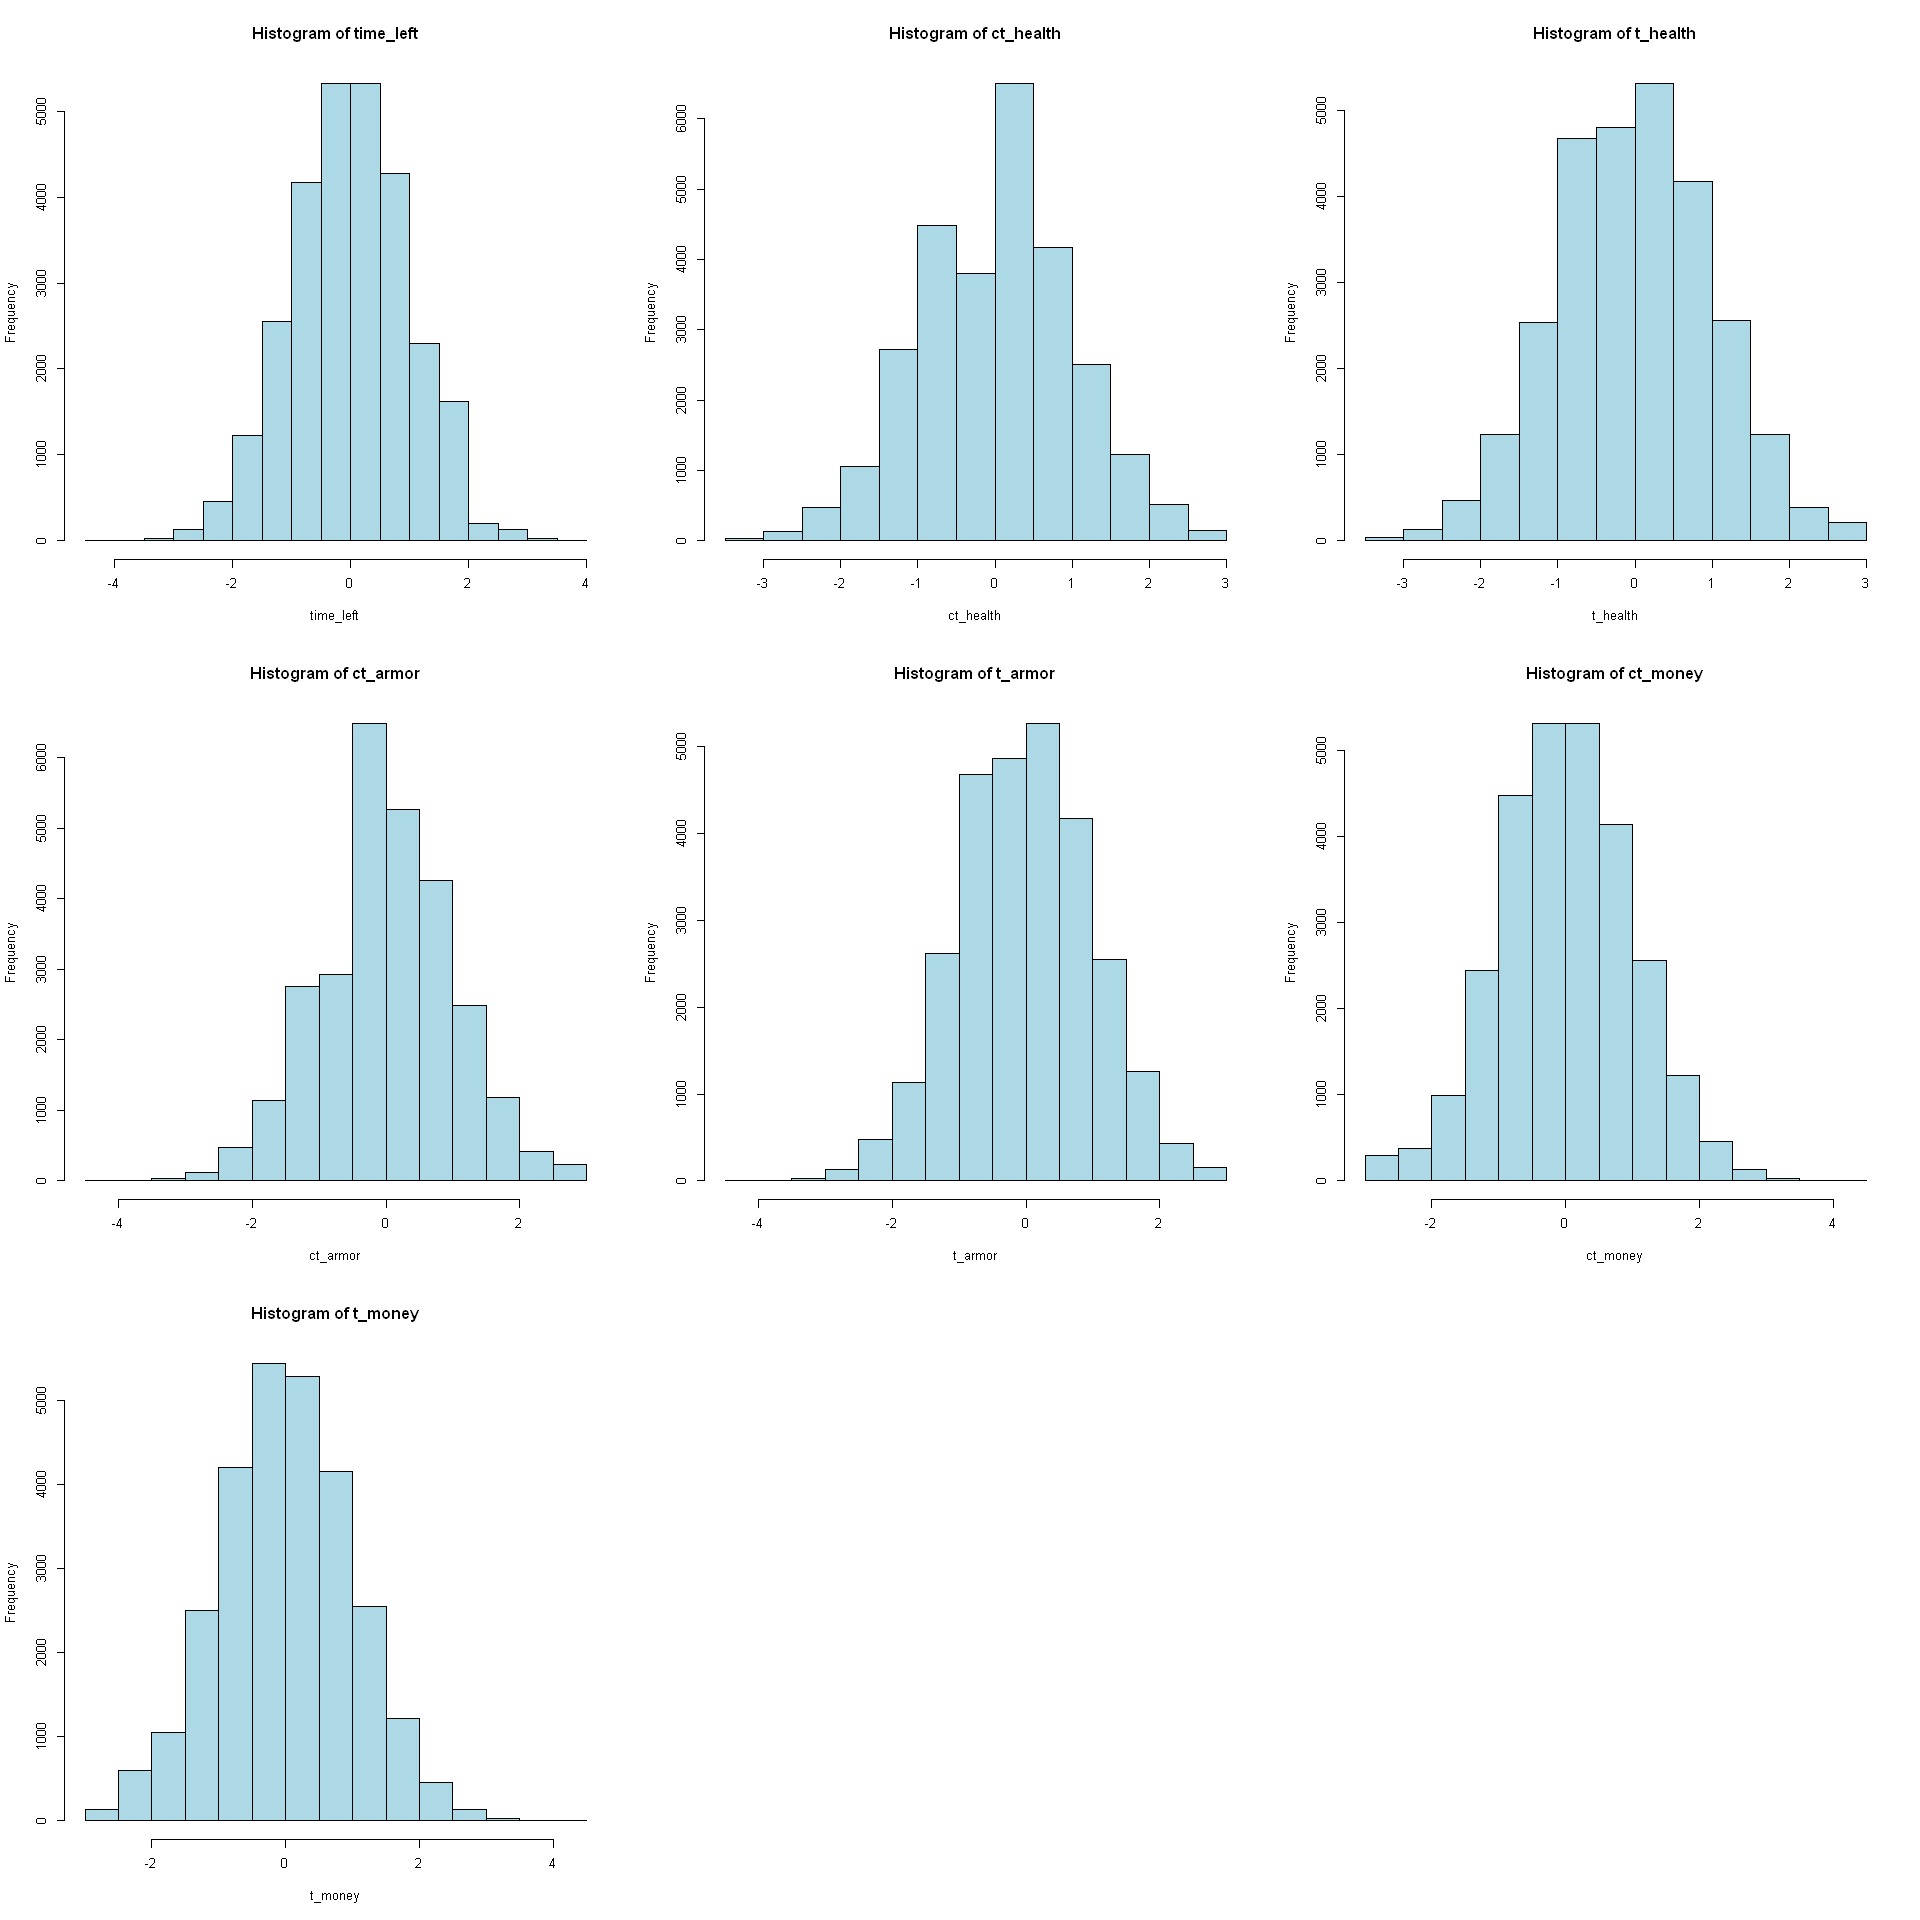

In [385]:
Dane <- Dane[!(Dane$t_health == 500 | Dane$ct_health == 500), ]
Dane <- Dane[!(Dane$t_armor == 500 | Dane$ct_armor == 500), ]
Dane <- Dane[!(Dane$t_armor == 0 | Dane$ct_armor == 0), ]

Dane_pred <- Dane_pred[!(Dane_pred$t_health == 500 | Dane_pred$ct_health == 500), ]
Dane_pred <- Dane_pred[!(Dane_pred$t_armor == 500 | Dane_pred$ct_armor == 500), ]
Dane_pred <- Dane_pred[!(Dane_pred$t_armor == 0 | Dane_pred$ct_armor == 0), ]

Znormalizowane_Dane <- Dane
Znormalizowane_Dane_pred <- Dane_pred
num_cols <- sapply(Dane, is.numeric)
par(mfrow = c(3, 3))
numeric_columns <- names(Dane)[num_cols]
for (col in numeric_columns[c(1,4:9)]) {
    transformed_data <- qnorm((rank(Dane[[col]]) - 0.5) / length(Dane[[col]]))
    transformed_data_pred <- qnorm((rank(Dane_pred[[col]]) - 0.5) / length(Dane_pred[[col]]))
    if (col == 'ct_armor' | col == 't_armor'){
        transformed_data <- qnorm((rank(log(Dane[[col]])) - 0.5) / length(Dane[[col]])) 
        transformed_data_pred <- qnorm((rank(log(Dane_pred[[col]])) - 0.5) / length(Dane_pred[[col]]))
        
        hist(transformed_data, main = paste("Histogram of", col), xlab = col, col = "lightblue", breaks = 20,border = "black")
                                        
    }
    else{
        hist(transformed_data, main = paste("Histogram of", col), xlab = col, col = "lightblue", breaks = 20,border = "black")
      
    }
    Znormalizowane_Dane_pred[[col]] = transformed_data_pred
    Znormalizowane_Dane[[col]] = transformed_data
}


In [386]:
head(Znormalizowane_Dane)

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,round_winner
,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
37010,0.93698534,1,0,de_inferno,False,1.7544220,1.7058935,2.6436381,-0.03273864,-0.4828786,-0.8192293,5,3,1,T
86687,0.43979794,4,11,de_nuke,False,-0.3620458,-0.9101187,-0.4751922,-1.36813023,-0.5706951,-1.3779668,0,0,1,CT
65529,-1.06076270,7,1,de_nuke,True,-0.3115559,-0.6423454,0.1145442,-0.17537962,0.6635491,-0.6789681,3,3,2,CT
12304,0.50012533,10,3,de_inferno,False,-0.4423323,-0.5037562,-0.2453195,-0.94795142,-0.4562474,-0.3690833,1,2,1,CT
74109,-0.01722389,13,14,de_overpass,False,-0.4614569,-0.8793714,-0.2390516,-0.57723374,-0.0675458,-1.8917118,2,2,2,CT
628,-0.16193422,12,15,de_nuke,True,-1.3046026,-0.6873948,-1.2088852,-0.76922728,-1.8562227,0.9852124,0,2,0,T


ta transformacja normalizuje time_left/ct_money/t_money (time_left można jeszcze bardziej znormalizować). Do pozostałych trzeba coś więcej

### Pairs

In [387]:
length(Znormalizowane_Dane[,1])

[1] 27798

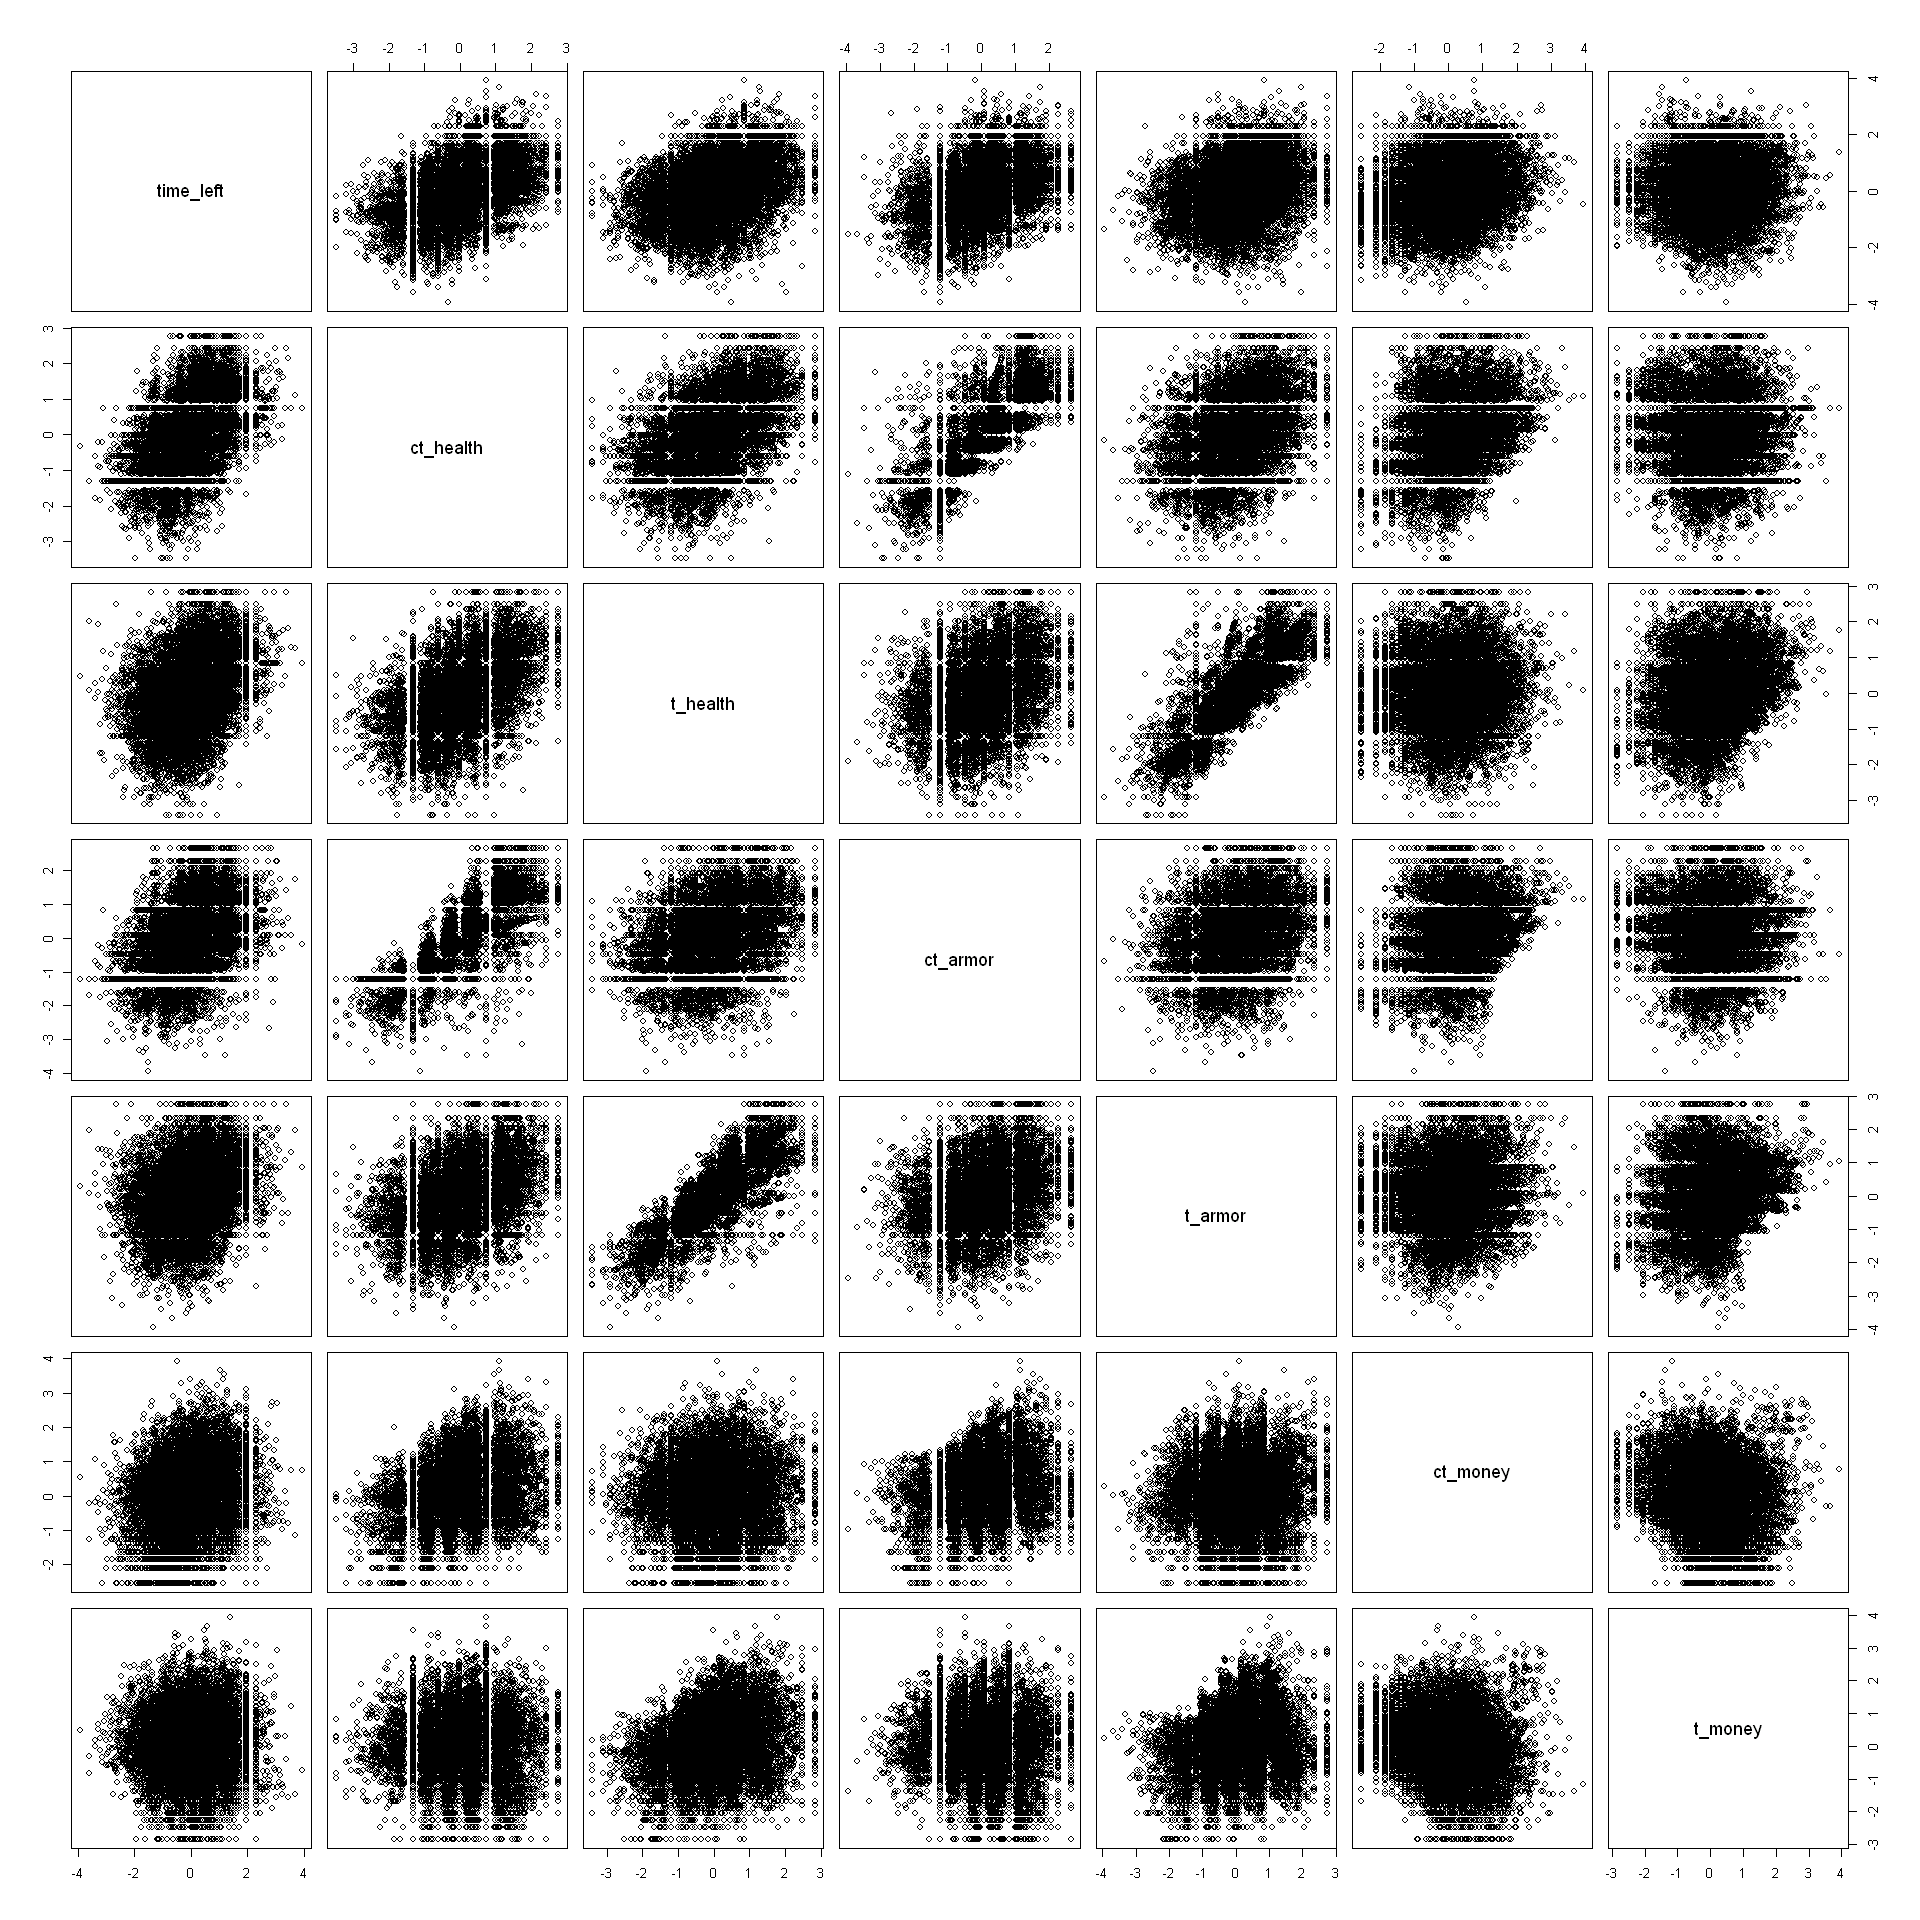

In [356]:
options(repr.plot.width=16, repr.plot.height=16) 

par(pin=c(10, 12))
pairs(Znormalizowane_Dane[,c(1,6:11)])

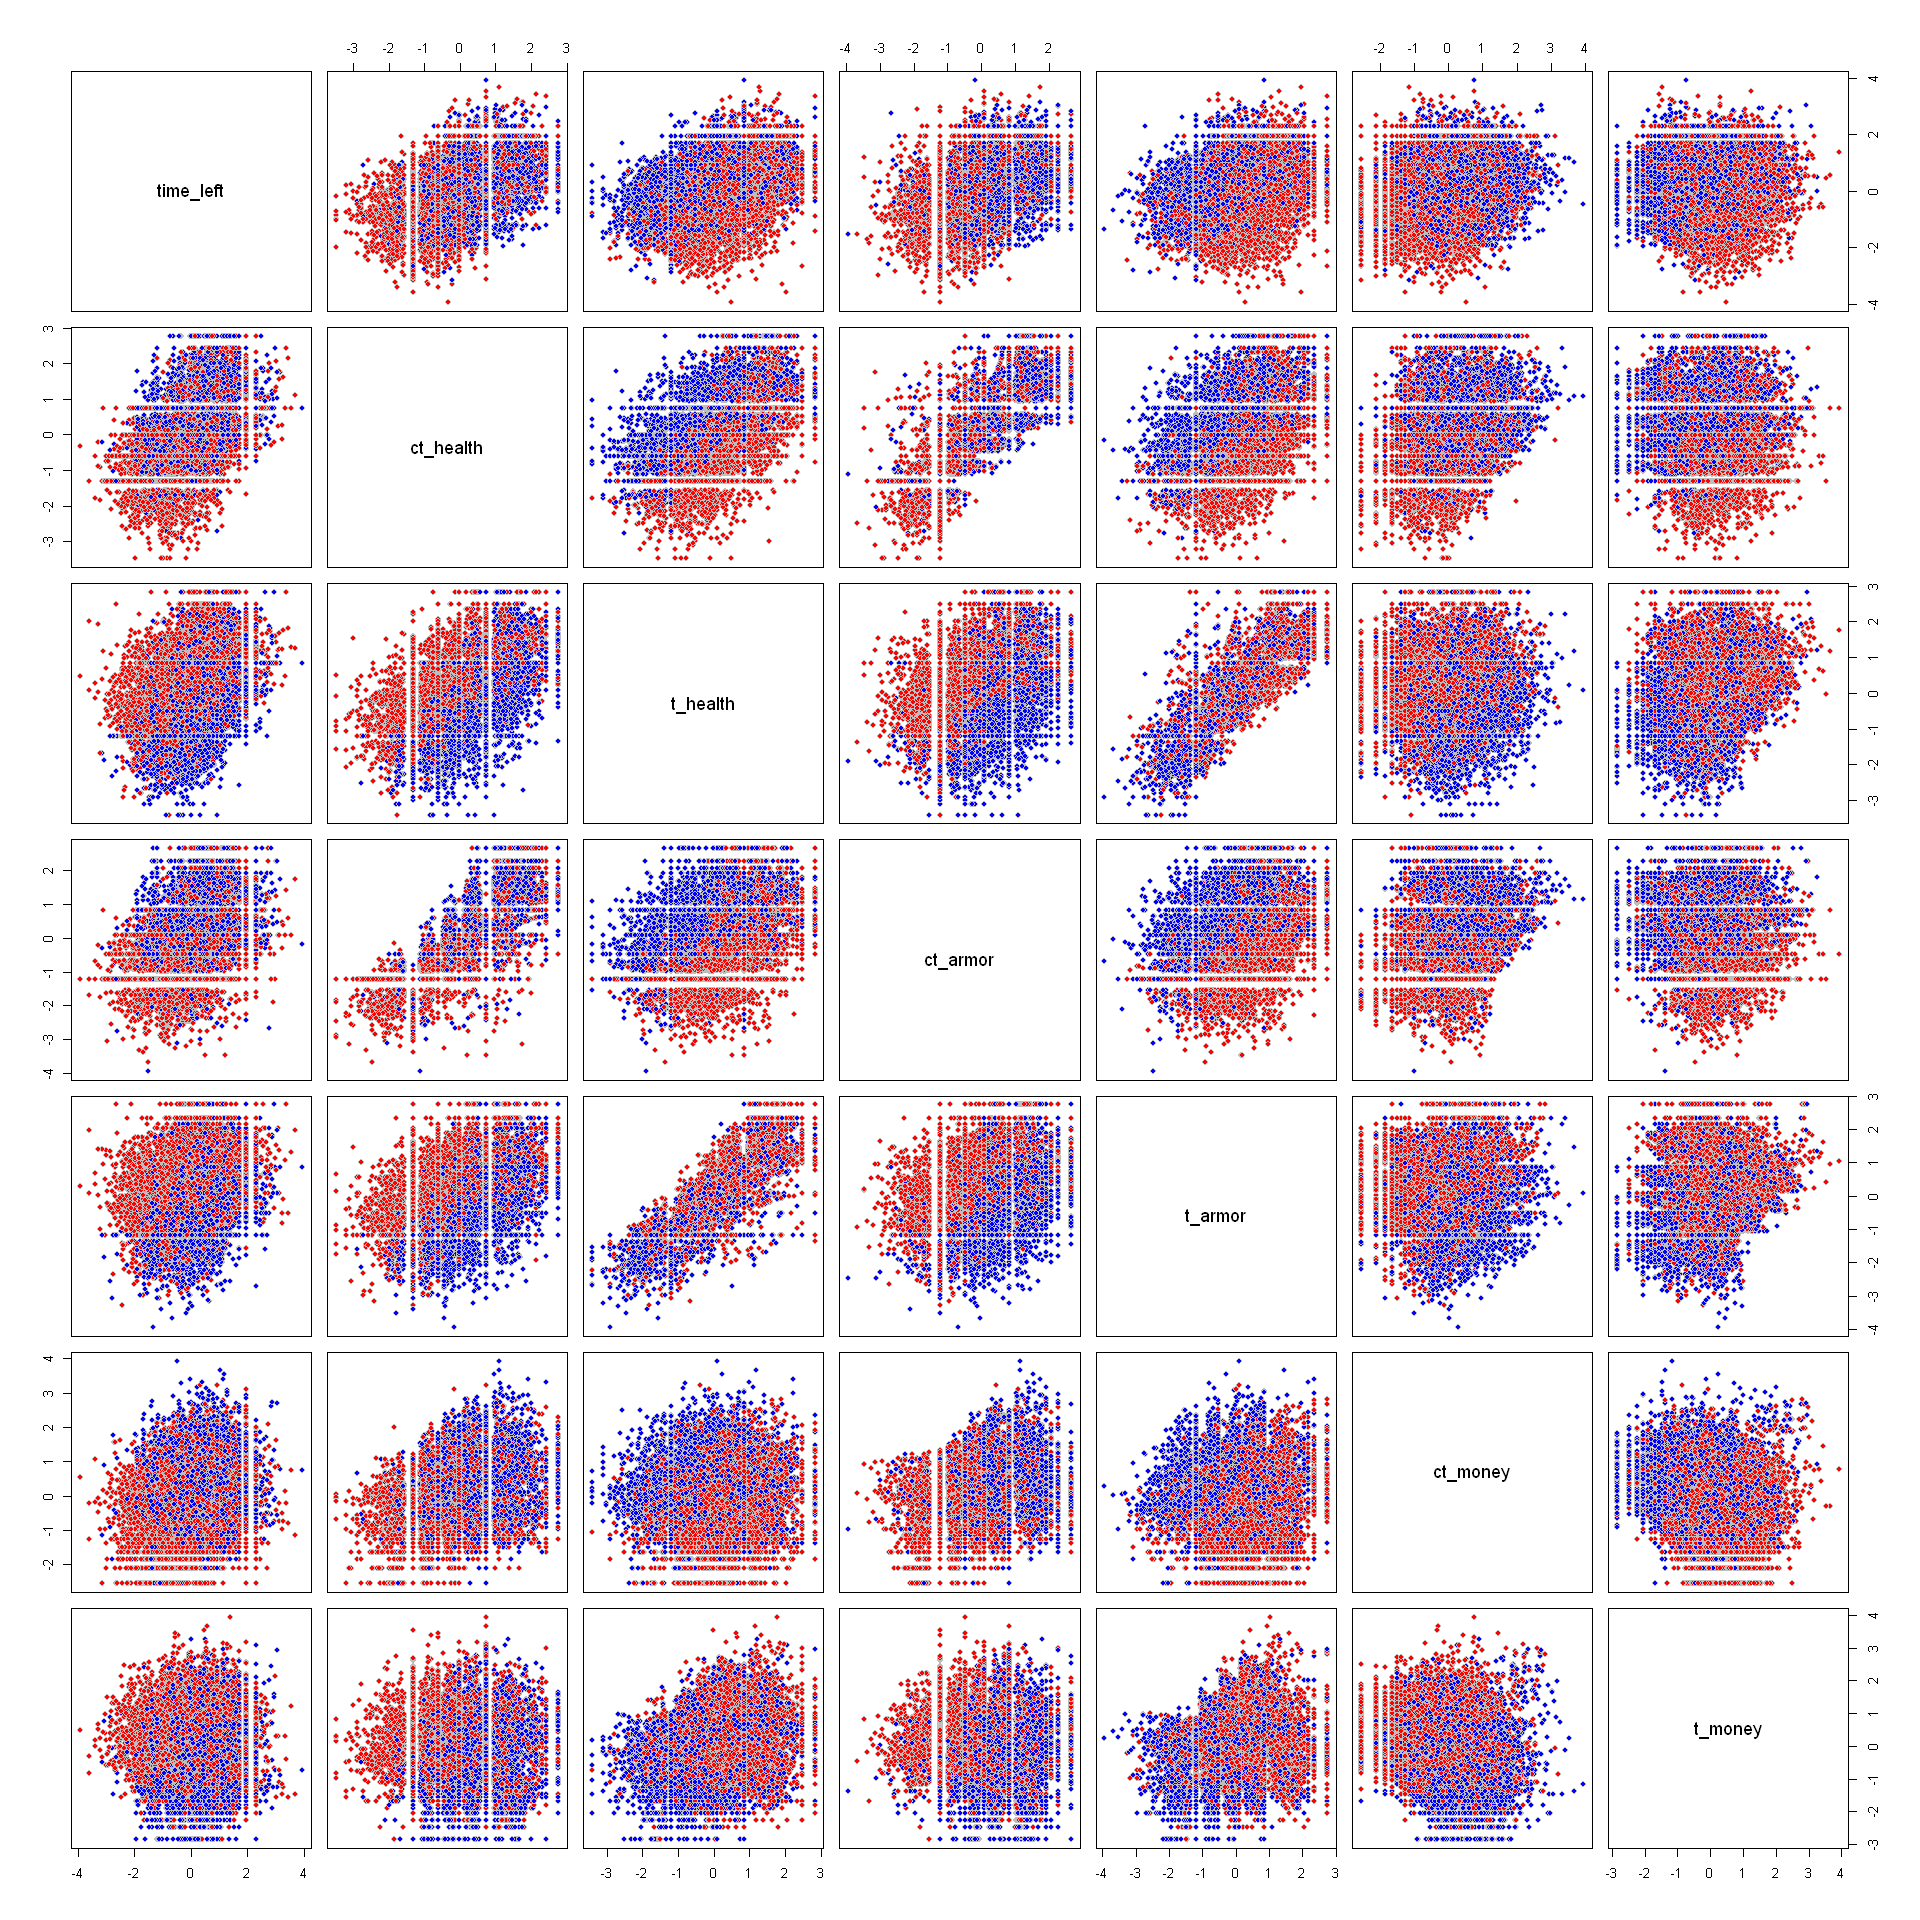

In [357]:
options(repr.plot.width=16, repr.plot.height=16) 
lookup <- c(CT = 'blue', T = 'red')
col.ind <- lookup[Dane$round_winner]
pairs(Znormalizowane_Dane[,c(1,6:11)], pch = 21, col = "gray", bg = col.ind)

## Korelacje

In [388]:
cor(Znormalizowane_Dane[,c(1,6:11)])

,time_left,ct_health,t_health,ct_armor,t_armor,ct_money,t_money
time_left,1.00000000,0.4913006,0.36500604,0.41195799,0.27488689,0.15281602,0.01445805
ct_health,0.49130058,1.0000000,0.46382491,0.83876742,0.36695944,0.32593144,-0.02065690
t_health,0.36500604,0.4638249,1.00000000,0.33668231,0.85851562,0.02268521,0.28155101
ct_armor,0.41195799,0.8387674,0.33668231,1.00000000,0.27680485,0.27547052,-0.03058599
t_armor,0.27488689,0.3669594,0.85851562,0.27680485,1.00000000,0.06146302,0.25233917
ct_money,0.15281602,0.3259314,0.02268521,0.27547052,0.06146302,1.00000000,-0.10736519
t_money,0.01445805,-0.0206569,0.28155101,-0.03058599,0.25233917,-0.10736519,1.00000000


## Analiza dyskryminacyjna

### LDA

In [419]:
Selected_Data <- Znormalizowane_Dane[,c(1,6:11,15)]
Selected_Data_pred <- Znormalizowane_Dane_pred[,c(1,6:11,15)]

In [390]:
lda.fit<- lda(round_winner ~ ., data = Selected_Data)

In [391]:
lda.fit

Call:
lda(round_winner ~ ., data = Selected_Data)

Prior probabilities of groups:
      CT        T 
0.438125 0.561875 

Group means:
    time_left  ct_health  t_health   ct_armor    t_armor   ct_money    t_money
CT  0.1622574  0.3644305 -0.297689  0.4235581 -0.3429011  0.2684447 -0.2531507
T  -0.1272659 -0.2843291  0.231623 -0.3294192  0.2668245 -0.2070807  0.1983904

Coefficients of linear discriminants:
                 LD1
time_left -0.1269940
ct_health -0.5052764
t_health   0.5326410
ct_armor  -0.5792360
t_armor    0.5274878
ct_money  -0.1785583
t_money    0.1368791

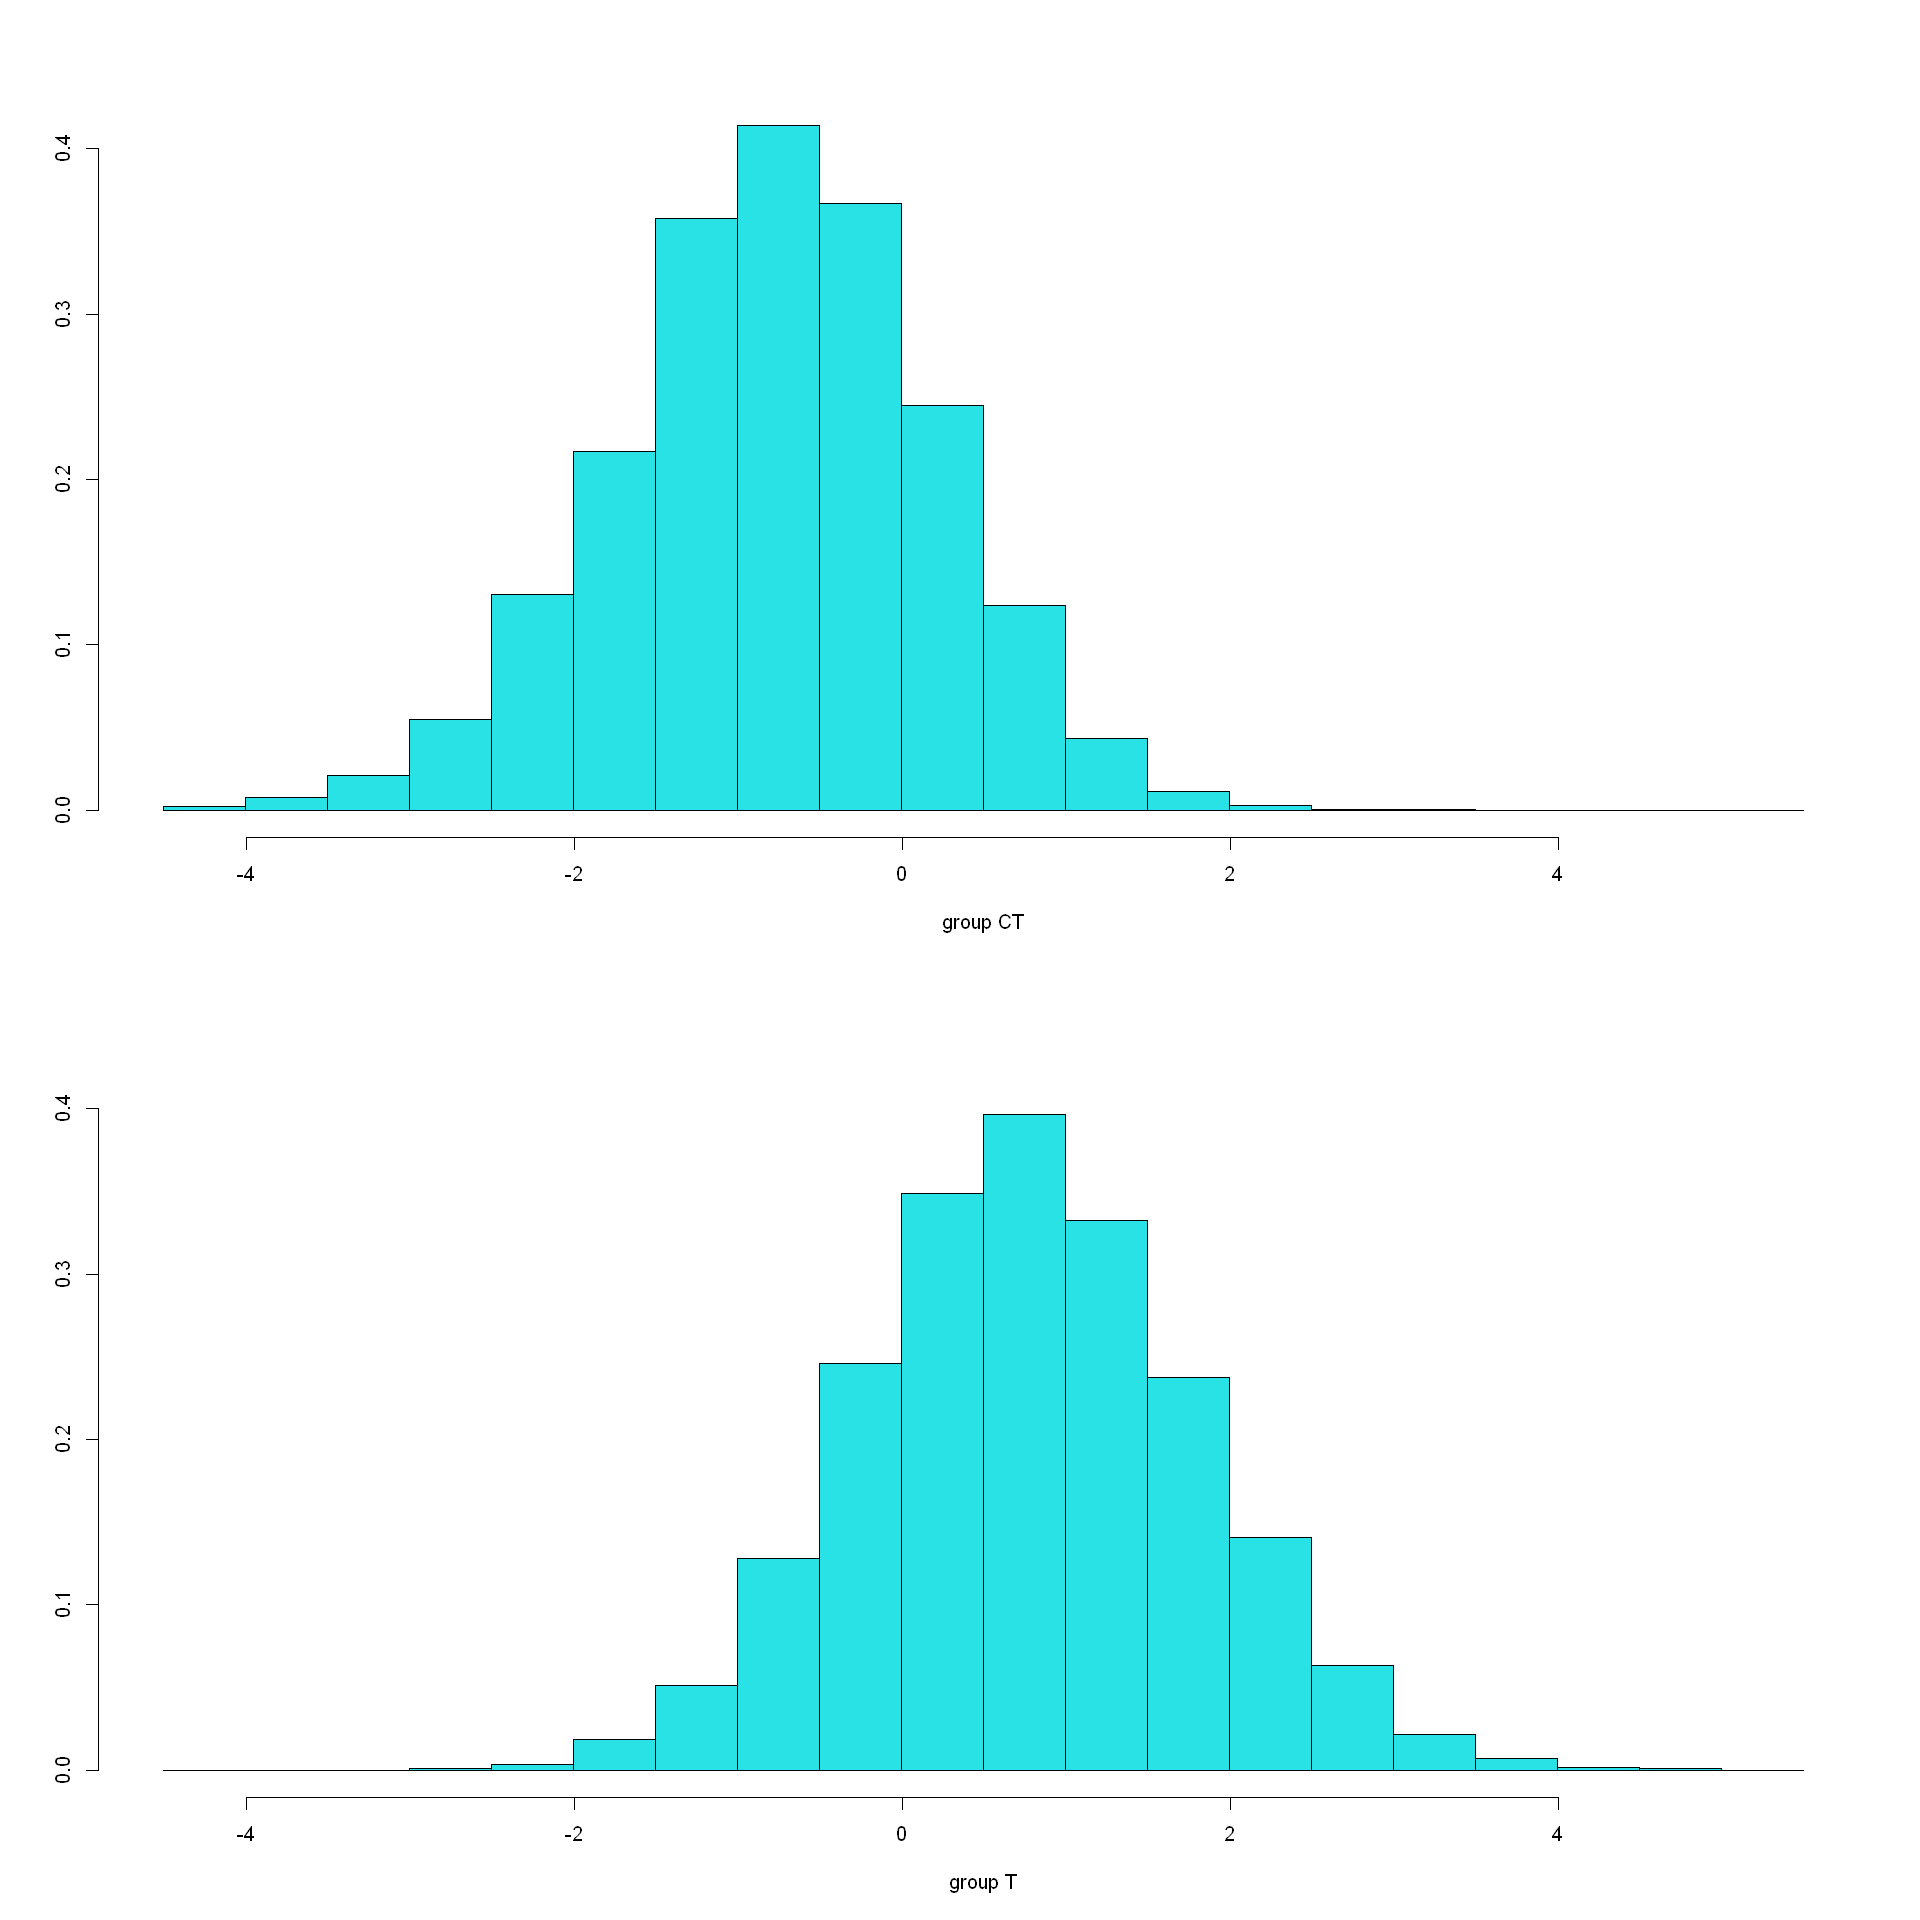

In [394]:
options(repr.plot.width=16, repr.plot.height=16) 
plot(lda.fit)

In [396]:
lda.pred <- predict(lda.fit, Selected_Data_pred)
lda.class <- lda.pred$class

In [397]:
table(lda.class, Selected_Data_pred[,8])

         
lda.class   CT    T
       CT 2153  712
       T   787 3198

In [398]:
mean(lda.class == Selected_Data_pred[,8])

[1] 0.7811679

### QDA

In [399]:
qda.fit <- qda(round_winner ~ ., data = Selected_Data)
qda.fit

Call:
qda(round_winner ~ ., data = Selected_Data)

Prior probabilities of groups:
      CT        T 
0.438125 0.561875 

Group means:
    time_left  ct_health  t_health   ct_armor    t_armor   ct_money    t_money
CT  0.1622574  0.3644305 -0.297689  0.4235581 -0.3429011  0.2684447 -0.2531507
T  -0.1272659 -0.2843291  0.231623 -0.3294192  0.2668245 -0.2070807  0.1983904

In [400]:
qda.class <- predict(qda.fit, Selected_Data_pred)$class
table(qda.class, Selected_Data_pred[,8])
mean(qda.class == Selected_Data_pred[,8])

         
qda.class   CT    T
       CT 2180  769
       T   760 3141

[1] 0.7767883

### MDA/FDA/RDA

#### MDA

In [428]:
mda_model <- Mclust(Selected_Data[, -which(names(Selected_Data) == "round_winner")], G = 2)
summary(mda_model)

---------------------------------------------------- 
Gaussian finite mixture model fitted by EM algorithm 
---------------------------------------------------- 

Mclust VVV (ellipsoidal, varying volume, shape, and orientation) model with 2
components: 

 log-likelihood     n df       BIC       ICL
        -218850 27798 71 -438426.5 -446218.6

Clustering table:
    1     2 
 9354 18444 

In [429]:
levels(Selected_Data$round_winner)

predicted_levels <- c("CT" = 1, "T" = 2)

predictions_test_converted <- names(predicted_levels)[match(predictions_test, predicted_levels)]

correct_predictions <- sum(predictions_test_converted == Selected_Data_pred$round_winner)

total_predictions <- length(predictions_test_converted)

accuracy <- correct_predictions / total_predictions

print(paste("Accuracy:", round(accuracy * 100, 2), "%"))

[1] "CT" "T"

[1] "Accuracy: 52.2 %"


#### FDA

In [441]:
library(fda)

fda_model <- fda(round_winner ~ ., data = Selected_Data)
predictions_test <- predict(fda_model, newdata = Selected_Data_pred)
actuals <- Selected_Data_pred$round_winner
accuracy <- sum(predictions_test == actuals) / length(actuals)
print(paste("Accuracy:", round(accuracy * 100, 2), "%"))

confusion_matrix <- table(Predicted = predictions_test, Actual = actuals)
print(confusion_matrix)

[1] "Accuracy: 78.12 %"
         Actual
Predicted   CT    T
       CT 2153  712
       T   787 3198


#### RDA

In [449]:
rda_model <- train(round_winner ~ ., data = Selected_Data, method = "rda")

predictions_test <- predict(rda_model, newdata = Selected_Data_pred)

actuals <- Selected_Data_pred$round_winner

accuracy <- sum(predictions_test == actuals) / length(actuals)

print(paste("Accuracy:", round(accuracy * 100, 2), "%"))

confusion_matrix <- table(Predicted = predictions_test, Actual = actuals)
print(confusion_matrix)

[1] "Accuracy: 78.12 %"
         Actual
Predicted   CT    T
       CT 2153  712
       T   787 3198
